<a href="https://colab.research.google.com/github/Jingi2103/Asia-Cup-2025---Cricket-Analysis/blob/main/cric_analysis%20Asia%20cup%202025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

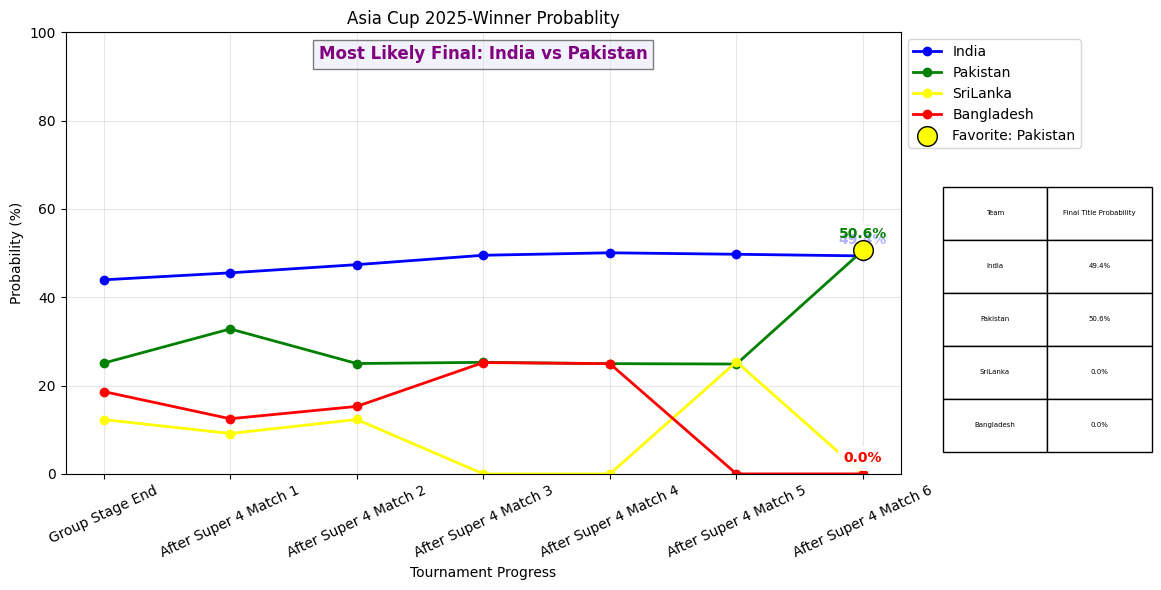

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
#Teams and remaining matches
# -------------------------
teams = {
    "India":      {"wins": 4, "matches": 4, "nrr": 0.689, "chase_adv": 1, "defend_adv": 1},
    "Pakistan":   {"wins": 3, "matches": 5, "nrr": 0.226, "chase_adv": 1, "defend_adv": 0.5},
    "SriLanka":   {"wins": 3, "matches": 5, "nrr": -0.590, "chase_adv": 1, "defend_adv": 0},
    "Bangladesh": {"wins": 3, "matches": 4, "nrr": 0.121, "chase_adv": 1, "defend_adv": 0.5},
}

remaining_matches_master = [
    ("Bangladesh", "SriLanka"),
    ("Pakistan", "India"),
    ("Pakistan", "SriLanka"),
    ("India", "Bangladesh"),
    ("Pakistan", "Bangladesh"),
    ("India", "SriLanka"),
]

# -------------------------
#Win probability with toss + strategy
# -------------------------
def win_prob(t1, t2):
    def strength(t):
        win_rate = teams[t]["wins"] / max(1, teams[t]["matches"])
        return max(0.01, win_rate * (1 + max(-0.99, teams[t]["nrr"])))

    s1, s2 = strength(t1), strength(t2)
    base_prob = s1 / (s1 + s2)

    toss_winner = random.choice([t1, t2])
    if toss_winner == t1:
        adv = max(teams[t1]["chase_adv"], teams[t1]["defend_adv"])
        base_prob = min(1, base_prob + adv)
    else:
        adv = max(teams[t2]["chase_adv"], teams[t2]["defend_adv"])
        base_prob = max(0, base_prob - adv)

    return base_prob

# -------------------------
#Monte Carlo simulation
# -------------------------
def simulate_asia_cup(rem_matches, n_sims=50000):
    titles = {t: 0 for t in teams}
    final_matchups = {}

    for _ in range(n_sims):
        wins = {t: teams[t]["wins"] for t in teams}
        matches = {t: teams[t]["matches"] for t in teams}

        for a, b in rem_matches:
            if random.random() < win_prob(a, b):
                wins[a] += 1
            else:
                wins[b] += 1
            matches[a] += 1
            matches[b] += 1

        finalists = sorted(
            teams.keys(),
            key=lambda x: (wins[x], teams[x]["nrr"]),
            reverse=True
        )[:2]

        final_pair = tuple(sorted(finalists))
        final_matchups[final_pair] = final_matchups.get(final_pair, 0) + 1

        f1, f2 = finalists
        champ = f1 if random.random() < win_prob(f1, f2) else f2
        titles[champ] += 1

    title_prob = {t: titles[t] / n_sims for t in teams}
    most_likely_final = max(final_matchups.items(), key=lambda x: x[1])[0]
    favorite = f1 if title_prob[f1] > title_prob[f2] else f2


    return title_prob, most_likely_final, favorite

# -------------------------
#Track probabilities over time
# -------------------------
timeline_labels = []
title_history = {t: [] for t in teams}

# Initial snapshot
timeline_labels.append("Group Stage End")
tp, final_pair, favorite = simulate_asia_cup(remaining_matches_master)
for t in teams:
    title_history[t].append(tp[t])

remaining_dynamic = remaining_matches_master.copy()
for i in range(len(remaining_matches_master)):
    remaining_dynamic = remaining_dynamic[1:]
    timeline_labels.append(f"After Super 4 Match {1+i}")
    tp, final_pair, favorite = simulate_asia_cup(remaining_dynamic)
    for t in teams:
        title_history[t].append(tp[t])

# -------------------------
#Plot chart (one line per team)
# -------------------------
colors = ["blue", "green", "yellow", "red"]
plt.figure(figsize=(12,6))

# --- Plot lines and annotate last points
for idx, team in enumerate(teams):
    y_percent = [v*100 for v in title_history[team]]
    plt.plot(timeline_labels, y_percent, marker='o', color=colors[idx], linewidth=2, label=f"{team}")

    # annotate last point above the marker
    plt.text(len(timeline_labels)-1, y_percent[-1]+2, f"{y_percent[-1]:.1f}%",
             color=colors[idx], fontweight='bold', fontsize=10,
             ha='center', va='bottom',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Highlight favorite in final
last_idx = len(timeline_labels) - 1
plt.scatter(last_idx, title_history[favorite][-1]*100, s=200, edgecolors='black', facecolors='yellow', zorder=5, label=f"Favorite: {favorite}")

# Annotate most likely final
plt.text(0.5, 0.95, f"Most Likely Final: {final_pair[0]} vs {final_pair[1]}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=12, fontweight='bold', color='purple', bbox=dict(facecolor='lavender', alpha=0.5))

plt.title("Asia Cup 2025-Winner Probablity")
plt.xlabel("Tournament Progress")
plt.ylabel("Probability (%)")
plt.ylim(0, 100)
plt.xticks(rotation=25)
plt.grid(True, alpha=0.3)

# --- Legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# --- Add table outside the plot area showing final probabilities
final_probs = [[team, f"{title_history[team][-1]*100:.1f}%"] for team in teams]
plt.table(cellText=final_probs,
          colLabels=["Team", "Final Title Probability"],
          cellLoc='center',
          colLoc='center',
          loc='right',  # outside right
          bbox=[1.05, 0.05, 0.25, 0.6])  # x, y (lowered), width, height

plt.tight_layout()
plt.show()